In [1]:
%matplotlib inline


# Data transformations

The statistics of intermittent precipitation rates are particularly non-Gaussian
and display an asymmetric distribution bounded at zero.
Such properties restrict the usage of well-established statistical methods that
assume symmetric or Gaussian data.

A common workaround is to introduce a suitable data transformation to approximate
a normal distribution.

In this example, we test the data transformation methods available in pysteps
in order to obtain a more symmetric distribution of the precipitation data
(excluding the zeros).
The currently available transformations include the Box-Cox, dB, square-root and
normal quantile transforms.


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pysteps import io, rcparams
from pysteps.utils import conversion, transformation
from scipy.stats import skew

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the radar input images

First, we will import the sequence of radar composites.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201609281600", "%Y%m%d%H%M")
data_source = rcparams.data_sources["fmi"]

### Load the data from the archive



In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Get 1 hour of observations in the data archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_next_files=11
)

# Read the radar composites
importer = io.get_method(importer_name, "importer")
Z, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Keep only positive rainfall values
Z = Z[Z > metadata["zerovalue"]].flatten()

# Convert to rain rate
R, metadata = conversion.to_rainrate(Z, metadata)

## Test data transformations



In [5]:
# Define method to visualize the data distribution with boxplots and plot the
# corresponding skewness
def plot_distribution(data, labels, skw):

    N = len(data)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax2.plot(np.arange(N + 2), np.zeros(N + 2), ":r")
    ax1.boxplot(data, labels=labels, sym="", medianprops={"color": "k"})

    ymax = []
    for i in range(N):
        y = skw[i]
        x = i + 1
        ax2.plot(x, y, "*r", ms=10, markeredgecolor="k")
        ymax.append(np.max(data[i]))

    # ylims
    ylims = np.percentile(ymax, 50)
    ax1.set_ylim((-1 * ylims, ylims))
    ylims = np.max(np.abs(skw))
    ax2.set_ylim((-1.1 * ylims, 1.1 * ylims))

    # labels
    ax1.set_ylabel(r"Standardized values [$\sigma$]")
    ax2.set_ylabel(r"Skewness []", color="r")
    ax2.tick_params(axis="y", labelcolor="r")

### Box-Cox transform
The Box-Cox transform is a well-known power transformation introduced by
`Box and Cox (1964)`_. In its one-parameter version, the Box-Cox transform
takes the form T(x) = ln(x) for lambda = 0, or T(x) = (x**lambda - 1)/lambda
otherwise.

To find a suitable lambda, we will experiment with a range of values
and select the one that produces the most symmetric distribution, i.e., the
lambda associated with a value of skewness closest to zero.
To visually compare the results, the transformed data are standardized.




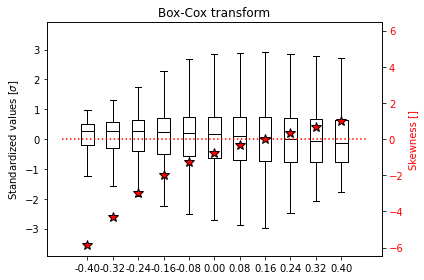

Best parameter lambda: 0.16
(skewness = 0.02)


In [6]:
data = []
labels = []
skw = []

# Test a range of values for the transformation parameter Lambda
Lambdas = np.linspace(-0.4, 0.4, 11)
for i, Lambda in enumerate(Lambdas):
    R_, _ = transformation.boxcox_transform(R, metadata, Lambda)
    R_ = (R_ - np.mean(R_)) / np.std(R_)
    data.append(R_)
    labels.append("{0:.2f}".format(Lambda))
    skw.append(skew(R_))  # skewness

# Plot the transformed data distribution as a function of lambda
plot_distribution(data, labels, skw)
plt.title("Box-Cox transform")
plt.tight_layout()
plt.show()

# Best lambda
idx_best = np.argmin(np.abs(skw))
Lambda = Lambdas[idx_best]

print("Best parameter lambda: %.2f\n(skewness = %.2f)" % (Lambda, skw[idx_best]))

### Compare data transformations



In [7]:
data = []
labels = []
skw = []

### Rain rates
First, let's have a look at the original rain rate values.



In [8]:
data.append((R - np.mean(R)) / np.std(R))
labels.append("R")
skw.append(skew(R))

### dB transform
We transform the rainfall data into dB units: 10*log(R)



In [9]:
R_, _ = transformation.dB_transform(R, metadata)
data.append((R_ - np.mean(R_)) / np.std(R_))
labels.append("dB")
skw.append(skew(R_))

### Square-root transform
Transform the data using the square-root: sqrt(R)



In [10]:
R_, _ = transformation.sqrt_transform(R, metadata)
data.append((R_ - np.mean(R_)) / np.std(R_))
labels.append("sqrt")
skw.append(skew(R_))

### Box-Cox transform
We now apply the Box-Cox transform using the best parameter lambda found above.



In [11]:
R_, _ = transformation.boxcox_transform(R, metadata, Lambda)
data.append((R_ - np.mean(R_)) / np.std(R_))
labels.append("Box-Cox\n($\lambda=$%.2f)" % Lambda)
skw.append(skew(R_))

### Normal quantile transform
At last, we apply the empirical normal quantile (NQ) transform as described in
`Bogner et al (2012)`_.




In [12]:
R_, _ = transformation.NQ_transform(R, metadata)
data.append((R_ - np.mean(R_)) / np.std(R_))
labels.append("NQ")
skw.append(skew(R_))

By plotting all the results, we can notice first of all the strongly asymmetric
distribution of the original data (R) and that all transformations manage to
reduce its skewness. Among these, the Box-Cox transform (using the best parameter
lambda) and the normal quantile (NQ) transform provide the best correction.
Despite not producing a perfectly symmetric distribution, the square-root (sqrt)
transform has the strong advantage of being defined for zeros, too, while all
other transformations need an arbitrary rule for non-positive values.



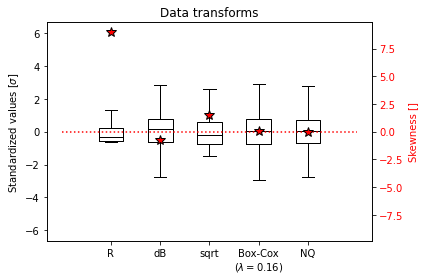

In [13]:
plot_distribution(data, labels, skw)
plt.title("Data transforms")
plt.tight_layout()
plt.show()